In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

## Data preparing

In [105]:
cancer_data = pd.read_csv('../../data/cancer_data_v4.csv')
cancer_data.drop(['WBC', 'EO%', 'EO', 'GLO', 'NEUT%', 'HCT', 'TCH','TBIL', 'IBIL', 'LDH-L'], axis=1, inplace=True)
for fea in cancer_data.columns[6:]:
    median = cancer_data.groupby(['Age_group', 'A=male B=female'])[fea].median()
    cancer_data.set_index(['Age_group', 'A=male B=female'], inplace=True)
    cancer_data[fea].fillna(median, inplace=True)
    cancer_data.reset_index(inplace=True)
cancer_data['A=Case, B=Control'] = cancer_data['A=Case, B=Control'].apply(lambda x: 1 if x=='A' else 0)
X_train, X_test, y_train, y_test = train_test_split(cancer_data.drop(['Origin','Age_group','A=male B=female','ID', 'A=Case, B=Control', 'Pattern'], axis=1), cancer_data['A=Case, B=Control'], test_size=0.3)

In [172]:
cancer_data2 = pd.read_csv('../../data/cancer_data_v4.csv')
for fea in cancer_data2.columns[6:]:
    median = cancer_data2.groupby(['Age_group', 'A=male B=female'])[fea].median()
    cancer_data2.set_index(['Age_group', 'A=male B=female'], inplace=True)
    cancer_data2[fea].fillna(median, inplace=True)
    cancer_data2.reset_index(inplace=True)
cancer_data2.to_csv('../../data/cancer_data_v5.csv')

In [106]:
print(len(X_train), len(X_test))

5454 2338


## RandomForestClassifier

In [146]:
rf = RandomForestClassifier(oob_score=True,random_state=0)
rf.fit(X_train, y_train)
print(rf_clf.oob_score_)

0.9314264759809314


### n_estimators

In [13]:
%%time
param_test1 = {'n_estimators':range(150,350,10)}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(max_features='sqrt' ,random_state=0), 
                       param_grid = param_test1, scoring='recall',cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

Wall time: 4min 47s


({'n_estimators': 280}, 0.9191555496349301)

### max_depth & min_samples_split

In [17]:
%%time
param_test2 = {'max_depth':range(10,30,5), 'min_samples_split':range(20,100,10)}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 280, max_features='sqrt' ,oob_score=True, random_state=0),
   param_grid = param_test2, scoring='recall', cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch2.best_score_

Wall time: 7min 51s


({'max_depth': 20, 'min_samples_split': 20}, 0.9184438058626879)

### min_samples_split & min_samples_leaf

In [178]:
%%time
param_test3 = {'min_samples_split':range(20,150,20), 'min_samples_leaf':range(10,60,10)}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 280, max_depth=20,max_features='sqrt' ,oob_score=True, random_state=10),
            param_grid = param_test3, scoring='recall', cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

Wall time: 6min 46s


({'min_samples_leaf': 10, 'min_samples_split': 20}, 0.9097793679189028)

### max_features

In [107]:
%%time
param_test4 = {'max_features':range(4,20,2)}
gsearch4 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 280, max_depth=20, min_samples_split=20,
                                  min_samples_leaf=20 ,oob_score=True, random_state=0),
param_grid = param_test4, scoring='recall', cv=5)
gsearch4.fit(X_train,y_train)
gsearch4.best_params_, gsearch4.best_score_

Wall time: 2min 49s


({'max_features': 4}, 0.906911984406358)

In [121]:
rf2 = RandomForestClassifier(n_estimators= 280, max_depth=20, min_samples_split=20,min_samples_leaf=20,oob_score=True, max_features=4)
rf2.fit(X_train,y_train)
y_pred = rf2.predict(X_test)
rf_prob = rf2.predict_proba(X_test)[:,1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prob)
rf_auc = auc(rf_fpr, rf_tpr)
print("ACC:",accuracy_score(y_test, y_pred))
print("REC:",recall_score(y_test, y_pred))
print("AUC:",rf_auc)

ACC: 0.9110350727117195
REC: 0.9117402164862615
AUC: 0.96921284447071


In [129]:
importances = pd.DataFrame(rf2.feature_importances_, columns = ['rf_importance'], index=X_train.columns).sort_values(by='rf_importance', ascending=False)

## XGBoost

In [113]:
from xgboost import XGBClassifier

In [151]:
xgb = XGBClassifier(random_state=0)
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
xgb_prob = xgb.predict_proba(X_test)[:,1]
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_prob)
xgb_auc = auc(xgb_fpr, xgb_tpr)
print("ACC:",accuracy_score(y_test, y_pred))
print("REC:",recall_score(y_test, y_pred))
print("AUC:",xgb_auc)

ACC: 0.9713430282292558
REC: 0.9616985845129059
AUC: 0.9896187360723291


In [144]:
xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### n_estimators

In [148]:
%%time
param_test1 = {'n_estimators':range(50,200,10)}
gsearch1 = GridSearchCV(estimator = XGBClassifier(random_state=0), 
                       param_grid = param_test1, scoring='recall',cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

Wall time: 25.2 s


({'n_estimators': 100}, 0.9502337122742224)

### min_child_weight & max_depth

In [156]:
%%time
param_test2 = {
 'max_depth':[2,3,4,5,6],
 'min_child_weight':[2,3,4,5,6,7]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(n_estimators=100,random_state=0), 
                       param_grid = param_test2, scoring='recall',cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch2.best_score_

Wall time: 27.8 s


({'max_depth': 3, 'min_child_weight': 3}, 0.9520245445976878)

### Gamma

In [161]:
%%time
param_test3 = {
 'gamma':[i/1000.0 for i in range(80,100)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(n_estimators=100,max_depth=3, min_child_weight=3, random_state=0), 
                       param_grid = param_test3, scoring='recall',cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

Wall time: 21.9 s


({'gamma': 0.081}, 0.9523823263508184)

### subsample & colsample_bytree

In [166]:
%%time
param_test4 = {
 'subsample':[i/100.0 for i in range(80,90)],
 'colsample_bytree':[i/100.0 for i in range(90,100)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(n_estimators=100,max_depth=3, min_child_weight=3, gamma=0.081, random_state=0), 
                       param_grid = param_test4, scoring='recall',cv=5)
gsearch4.fit(X_train,y_train)
gsearch4.best_params_, gsearch4.best_score_

Wall time: 1min 23s


({'colsample_bytree': 0.9, 'subsample': 0.8}, 0.9513089810914266)

### reg_alpha & reg_lambda

In [171]:
%%time
param_test5 = {
 'reg_alpha':[0, 1e-3, 2e-3, 3e-3, 4e-3],
 'reg_lambda': [2.5, 3, 3.5]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(n_estimators=100,max_depth=3, min_child_weight=3, gamma=0.081, colsample_bytree=0.9, subsample=0.8,random_state=0), 
                       param_grid = param_test5, scoring='recall',cv=5)
gsearch5.fit(X_train,y_train)
gsearch5.best_params_, gsearch5.best_score_

Wall time: 12.5 s


({'reg_alpha': 0.001, 'reg_lambda': 3}, 0.9520245445976879)

### learning_rate

In [174]:
%%time
param_test6 = {
    'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(n_estimators=100,max_depth=3, min_child_weight=3, gamma=0.081, colsample_bytree=0.9, subsample=0.8, reg_alpha=0.001, reg_lambda=3, random_state=0), 
                       param_grid = param_test6, scoring='recall',cv=5)
gsearch6.fit(X_train,y_train)
gsearch6.best_params_, gsearch6.best_score_

Wall time: 5.83 s


({'learning_rate': 0.3}, 0.9520245445976879)

In [175]:
xgb2 = XGBClassifier(n_estimators=100,max_depth=3, min_child_weight=3, gamma=0.081, colsample_bytree=0.9, subsample=0.8, reg_alpha=0.001, reg_lambda=3, learning_rate=0.3,random_state=0)
xgb2.fit(X_train,y_train)
y_pred = xgb2.predict(X_test)
xgb_prob = xgb2.predict_proba(X_test)[:,1]
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_prob)
xgb_auc = auc(xgb_fpr, xgb_tpr)
print("ACC:",accuracy_score(y_test, y_pred))
print("REC:",recall_score(y_test, y_pred))
print("AUC:",xgb_auc)

ACC: 0.9653550042771599
REC: 0.9592006661115737
AUC: 0.9908014209794389


In [177]:
importances['xgb_importance'] = pd.DataFrame(xgb2.feature_importances_, index=X_train.columns)
importances.sort_values(by='xgb_importance', ascending=False)

,rf_importance,xgb_importance
Smoke,0.153443,0.120294
T-CEA,0.116812,0.110624
GGT,0.084610,0.094486
BASO,0.067347,0.078656
BASO%,0.084056,0.069264
HGB,0.026121,0.056442
DBIL,0.025848,0.040447
HDL-C,0.045392,0.040386
MCV,0.045461,0.038161
RDW-CV,0.030843,0.029699


## AUC & ROC

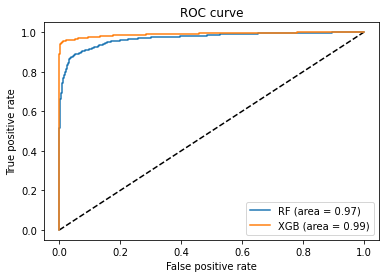

In [176]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(rf_fpr, rf_tpr, label='RF (area = %0.2f)' % rf_auc)
plt.plot(xgb_fpr, xgb_tpr, label='XGB (area = %0.2f)' % xgb_auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()